
# 03_cate_estimation.ipynb  
## Causal Forest, Uplift Evaluation, and Policy Learning on Criteo Uplift

This notebook estimates **conditional average treatment effects (CATE)** on a Criteo uplift dataset, and then uses the estimated CATE to learn and evaluate targeting policies.

We focus on:

1. **Identification and problem setup**  
2. **Causal Forest (CausalForestDML) CATE estimation**  
3. **Uplift evaluation**: uplift/Qini curves, AUUC, calibration checks  
4. **Policy evaluation**: treat top-q% based on predicted uplift  
5. **Interpretability**: which features drive heterogeneity?  
6. **Robustness checks**: alternative nuisance models and hyperparameters    


In [2]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from econml.dml import CausalForestDML

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 1. Identification

We observe i.i.d. data (Y, W, X) where:

- W in {0, 1} is randomized ad showing (treatment). My focus is on the impact of attempting to show the ad, rather than on actual exposure. This distinction matters operationally: exposure is a user-driven, post-assignment event that we cannot control. What the business controls—and what any targeting policy must optimize—is the decision to serve an ad.
- Y in {0, 1} is a binary outcome (e.g. conversion).  
- X are pre-treatment user or context features.

We are interested in the **conditional average treatment effect**:

tau(x) = E[Y(1) - Y(0) | X = x].

Because treatment is randomized, we assume:

1. **Unconfoundedness**: (Y(1), Y(0)) independent of W given X.  
2. **Overlap**: 0 < P(W = 1 | X=x) < 1.  
3. **SUTVA**: no interference, well-defined treatment.



## 2. Data loading and basic checks



In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
PROJECT_ROOT = Path().resolve().parents[0]  
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
df = pd.read_csv(RAW_DIR / "criteo-uplift-v2.1.csv")

The original dataset is too big for Causal Forest to run on local computer, so for demonstration, I will just subset the full data. 

In [4]:
EXPOSURE_COL = "exposure"  

N_PER_CELL = 50000
T_COL = "treatment"
Y_VISIT_COL = "visit"
Y_CONV_COL = "conversion"
OUTCOME_COLS = [Y_VISIT_COL, Y_CONV_COL]

df_small = (
    df.groupby([T_COL, Y_CONV_COL], group_keys=False)
      .apply(lambda g: g.sample(min(len(g), N_PER_CELL), random_state=RANDOM_STATE))
    .reset_index(drop=True)
)

EXCLUDE_COLS = [T_COL] + OUTCOME_COLS + [EXPOSURE_COL]
feature_cols = [c for c in df_small.columns if c not in EXCLUDE_COLS]

def prepare_data(df, y_col, test_size=0.2, random_state=RANDOM_STATE):
    EXCLUDE_COLS = [T_COL] + OUTCOME_COLS + [EXPOSURE_COL]
    feature_cols = [c for c in df.columns if c not in EXCLUDE_COLS]

    X = df[feature_cols].values
    W = df[T_COL].astype(int).values
    Y = df[y_col].astype(float).values

    print(f"Outcome: {y_col}")
    print("X shape:", X.shape)
    print("Treatment rate:", W.mean())
    print("Outcome rate:", Y.mean())

    X_train, X_test, W_train, W_test, Y_train, Y_test = train_test_split(
        X, W, Y,
        test_size=test_size,
        random_state=random_state,
        stratify=W
    )

    print("Train:", X_train.shape, "Test:", X_test.shape)
    return feature_cols, X_train, X_test, W_train, W_test, Y_train, Y_test

feature_cols, X_train, X_test, W_train, W_test, Y_train, Y_test = prepare_data(
    df_small, Y_CONV_COL
)


Outcome: conversion
X shape: (140774, 12)
Treatment rate: 0.6159589128674329
Outcome rate: 0.28964155312770823
Train: (112619, 12) Test: (28155, 12)


/var/folders/sx/jgx0y67n0v557w_2c0f5xj800000gn/T/ipykernel_57044/1196552636.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), N_PER_CELL), random_state=RANDOM_STATE))



## 3. Causal Forest CATE estimation

We use `CausalForestDML` (Wager & Athey style causal forest) with:

- Flexible nuisance models m(x) = E[Y | X] and e(x) = P(W=1 | X].  
- Honest sample splitting and cross-fitting for orthogonalization.  
- A random forest for the CATE function tau(x).


In [5]:

# Baseline nuisance models
model_t_gbm = GradientBoostingClassifier(random_state=RANDOM_STATE)
model_y_gbm = GradientBoostingRegressor(random_state=RANDOM_STATE)

cf = CausalForestDML(
    model_t=model_t_gbm,
    model_y=model_y_gbm,
    n_estimators=100,
    min_samples_leaf=20,
    max_depth=None,
    discrete_treatment=True,
    cv=3,                    
    random_state=RANDOM_STATE
)


cf.fit(Y_train, W_train, X=X_train)

tau_test_cf = cf.effect(X_test)
tau_test_cf_lb, tau_test_cf_ub = cf.effect_interval(X_test)

print(pd.Series(tau_test_cf).describe())


count    28155.000000
mean         0.137675
std          0.153747
min         -0.023378
25%          0.018532
50%          0.056551
75%          0.247805
max          0.594114
dtype: float64



## 4. Uplift and Qini evaluation

Because the true CATE is unknown, we evaluate models by:

- **Uplift curves**: cumulative difference in outcomes when targeting by predicted uplift.  
- **Qini curves / AUUC**: area under uplift curve as a summary metric.  
- **Decile-level realized ATE vs. predicted uplift** for calibration.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def uplift_by_decile(y, w, uplift_scores, n_groups=10):
    df_eval = pd.DataFrame({"y": y, "w": w, "score": uplift_scores})
    
    # Deciles by predicted uplift
    df_eval["group"] = pd.qcut(df_eval["score"], q=n_groups,
                               labels=False, duplicates="drop")

    grouped = df_eval.groupby("group")
    stats = grouped.apply(
        lambda g: pd.Series({
            "n": len(g),
            "y_treated": g.loc[g["w"] == 1, "y"].mean(),
            "y_control": g.loc[g["w"] == 0, "y"].mean()
        })
    )

    # Average predicted uplift (for calibration plot)
    stats["avg_score"] = grouped["score"].mean()

    # Realized uplift per decile
    stats["uplift"] = stats["y_treated"] - stats["y_control"]
    
    # For uplift curve, sort from best (highest score) to worst
    stats = stats.sort_values("avg_score", ascending=False)

    stats["frac"] = stats["n"] / stats["n"].sum()
    stats["weighted_uplift"] = stats["uplift"] * stats["frac"]
    stats["cum_frac"] = stats["frac"].cumsum()
    stats["cum_uplift"] = stats["weighted_uplift"].cumsum()
    
    return stats.reset_index()


# ---------------------------------------------------------------------

def plot_uplift_curve(stats, label=None, total_uplift=None):
    plt.plot(stats["cum_frac"], stats["cum_uplift"], marker="o", label=label)
    
    # Benchmarking logic: Plotting the Random Baseline
    if total_uplift is None:
        # If total_uplift isn't passed, use the last point of the model curve
        total_uplift = stats["cum_uplift"].iloc[-1] 
    
    # The Random Benchmark goes from (0, 0) to (1.0, total_uplift)
    x_random = [0.0, 1.0]
    y_random = [0.0, total_uplift]
    plt.plot(x_random, y_random, label="Random Baseline", color='grey', linestyle='--')
    
    plt.xlabel("Fraction of population (sorted by predicted uplift)")
    plt.ylabel("Cumulative uplift")
    plt.grid(True)
    plt.legend()



In [7]:
def auuc(stats):
    """Compute the Area Under the Uplift Curve (AUUC).

    The input DataFrame should contain cumulative fractions (`cum_frac`)
    and cumulative uplift values (`cum_uplift`) sorted from the highest
    to the lowest predicted uplift.
    """
    # Anchor the curve at the origin for accurate integration
    x = np.concatenate([[0.0], stats["cum_frac"].to_numpy()])
    y = np.concatenate([[0.0], stats["cum_uplift"].to_numpy()])
    return np.trapz(y=y, x=x)


/var/folders/sx/jgx0y67n0v557w_2c0f5xj800000gn/T/ipykernel_57044/1611649039.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = grouped.apply(


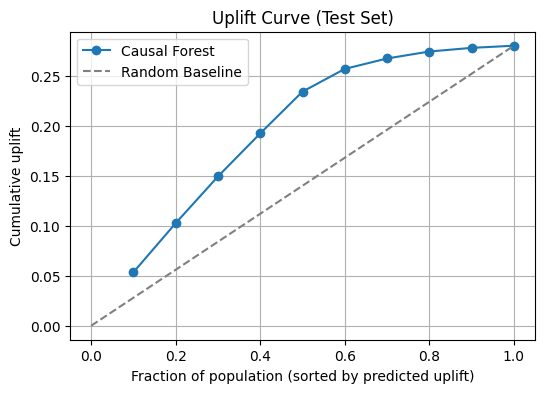

In [8]:
stats_cf = uplift_by_decile(Y_test, W_test, tau_test_cf, n_groups=10)
plot_uplift_curve(stats_cf, label="Causal Forest") 
plt.title("Uplift Curve (Test Set)")
plt.show()

The uplift curve shows that the causal forest meaningfully outperforms random targeting across nearly the entire population.


### 4.1 Calibration of uplift

We check whether higher predicted uplift corresponds to higher realized treatment-control differences.


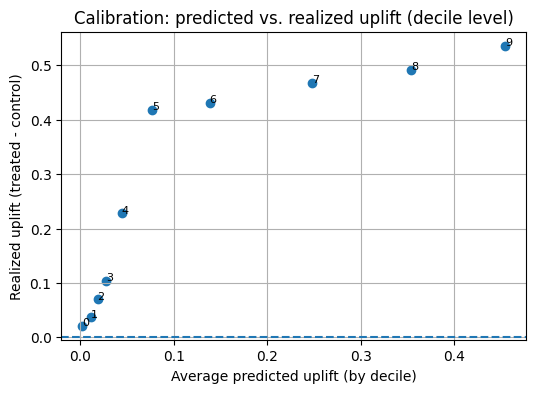

In [9]:
# For calibration, re-order from low to high predicted uplift
calib = stats_cf.sort_values("avg_score")

plt.figure()
plt.scatter(calib["avg_score"], calib["uplift"])
for _, row in calib.iterrows():
    plt.text(row["avg_score"], row["uplift"], str(int(row["group"])), fontsize=8)

plt.axhline(0, linestyle="--")  # zero-uplift reference
plt.xlabel("Average predicted uplift (by decile)")
plt.ylabel("Realized uplift (treated - control)")
plt.title("Calibration: predicted vs. realized uplift (decile level)")
plt.grid(True)
plt.show()

This calibration plot evaluates how well the model’s predicted uplift aligns with the true causal effect observed in each decile of predicted scores. The pattern is strongly monotonic: deciles with higher predicted uplift consistently exhibit higher realized uplift. The lowest-scoring deciles show near-zero treatment impact, while the top deciles display substantially positive causal effects, reaching roughly 0.5 in the highest group. This indicates that the model is successfully ranking individuals by their true responsiveness to treatment, even if its absolute predictions are conservative. In other words, while the model may underestimate the magnitude of uplift, it is highly effective at identifying which users benefit most from treatment.


## 5. Policy learning and evaluation

Define a **policy** that treats the top-q% of users by predicted uplift.  
We estimate the expected outcome under this policy using an inverse-propensity weighting estimator, exploiting randomization.


In [10]:

def treatment_policy(scores, q=0.3):
    n = len(scores)
    cutoff = int(np.floor(q * n))
    order = np.argsort(scores)[::-1]
    policy = np.zeros(n, dtype=int)
    policy[order[:cutoff]] = 1
    return policy

def estimate_policy_value(y, w, policy, p_treat=None):
    if p_treat is None:
        p_treat = w.mean()

    mask_tt = (policy == 1) & (w == 1)
    mask_cc = (policy == 0) & (w == 0)

    y_t = y[mask_tt]
    y_c = y[mask_cc]

    if len(y_t) == 0 or len(y_c) == 0:
        return np.nan

    wt_t = 1.0 / p_treat
    wt_c = 1.0 / (1.0 - p_treat)

    num = (wt_t * y_t).sum() + (wt_c * y_c).sum()
    den = len(y_t) * wt_t + len(y_c) * wt_c

    return num / den


In [11]:

p_treat = W_train.mean()

# Empirical average outcome by arm in the experiment:
baseline_treat_all   = Y_test[W_test == 1].mean()  # “treat all” => use effect we observed on treated
baseline_treat_none  = Y_test[W_test == 0].mean()  # “treat none” => use control outcomes
print (f"Baseline treat all:  {baseline_treat_all:.6f}")
print (f"Baseline treat none: {baseline_treat_none:.6f}")

for q in [0.1, 0.2, 0.3, 0.5, 0.8]:
    policy_cf = treatment_policy(tau_test_cf, q=q)
    value_cf = estimate_policy_value(Y_test, W_test, policy_cf, p_treat)
    print(f"Top {int(q*100)}% by CF uplift: value = {value_cf:.6f}")


Baseline treat all:  0.423884
Baseline treat none: 0.075927
Top 10% by CF uplift: value = 0.151295
Top 20% by CF uplift: value = 0.204281
Top 30% by CF uplift: value = 0.249665
Top 50% by CF uplift: value = 0.322577
Top 80% by CF uplift: value = 0.386033



## 6. Robustness checks

We now vary:

1. **Nuisance models** (m, e): GBM vs simpler logistic / random forest.  
2. **Forest hyperparameters**: depth, number of trees.

The goal is not exhaustive tuning but checking whether the **ranking of uplift** and policy value are reasonably stable.


In [12]:

def fit_cf_and_policy_value(X_train, W_train, Y_train, X_test, W_test, Y_test,
                            model_y, model_t,
                            n_estimators=300,
                            min_samples_leaf=50,
                            label=""):
    cf_tmp = CausalForestDML(
        model_t=model_t,
        model_y=model_y,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_depth=None,
        discrete_treatment=True,
        cv=3,
        random_state=RANDOM_STATE,
    )
    cf_tmp.fit(Y_train, W_train, X=X_train)
    tau_test_tmp = cf_tmp.effect(X_test)

    stats_tmp = uplift_by_decile(Y_test, W_test, tau_test_tmp, n_groups=10)
    auuc_tmp = auuc(stats_tmp)

    p_treat = W_train.mean()
    policy_tmp = treatment_policy(tau_test_tmp, q=0.3)
    value_tmp = estimate_policy_value(Y_test, W_test, policy_tmp, p_treat)

    print(f"{label}: AUUC = {auuc_tmp:.6f}, Policy value (q=0.3) = {value_tmp:.6f}")
    return tau_test_tmp, auuc_tmp, value_tmp


In [13]:

# Baseline (already fit above) -- recompute metrics for direct comparison
stats_cf_base = uplift_by_decile(Y_test, W_test, tau_test_cf, n_groups=10)
auuc_base = auuc(stats_cf_base)
p_treat = W_train.mean()
policy_base = treatment_policy(tau_test_cf, q=0.3)
value_base = estimate_policy_value(Y_test, W_test, policy_base, p_treat)
print(f"Baseline CF: AUUC = {auuc_base:.6f}, Policy value (q=0.3) = {value_base:.6f}")

# Alternative nuisance: simpler models
model_y_rf = RandomForestRegressor(
    n_estimators=200, max_depth=10, min_samples_leaf=50, random_state=RANDOM_STATE
)
model_t_lr = LogisticRegression(max_iter=1000)

tau_rf_lr, auuc_rf_lr, value_rf_lr = fit_cf_and_policy_value(
    X_train, W_train, Y_train,
    X_test, W_test, Y_test,
    model_y=model_y_rf,
    model_t=model_t_lr,
    n_estimators=300,
    min_samples_leaf=50,
    label="CF (Y=RF, T=Logit)"
)

# Slight hyperparameter change
tau_gbm_shallow, auuc_gbm_shallow, value_gbm_shallow = fit_cf_and_policy_value(
    X_train, W_train, Y_train,
    X_test, W_test, Y_test,
    model_y=model_y_gbm,
    model_t=model_t_gbm,
    n_estimators=200,
    min_samples_leaf=100,
    label="CF (shallow forest)"
)


/var/folders/sx/jgx0y67n0v557w_2c0f5xj800000gn/T/ipykernel_57044/1611649039.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = grouped.apply(


Baseline CF: AUUC = 0.195256, Policy value (q=0.3) = 0.249665


/var/folders/sx/jgx0y67n0v557w_2c0f5xj800000gn/T/ipykernel_57044/1611649039.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = grouped.apply(


CF (Y=RF, T=Logit): AUUC = 0.195923, Policy value (q=0.3) = 0.250086
CF (shallow forest): AUUC = 0.195604, Policy value (q=0.3) = 0.250630


/var/folders/sx/jgx0y67n0v557w_2c0f5xj800000gn/T/ipykernel_57044/1611649039.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = grouped.apply(


In [ ]:
print(auuc_rf_lr, value_rf_lr)

print(auuc_gbm_shallow, value_gbm_shallow)

0.19318935149252406 0.2500859461436214
0.19288905905883505 0.250630386336072


The results look very similar, so our models are stable. 


## 7. Summary and discussion

- We estimated CATE using a causal forest with orthogonalization and cross-fitting.  
- We evaluated uplift using uplift curves, AUUC, and decile-level calibration.  
- Unfortunately, we failed to derive an effective treatment policy. Assuming zero treatment costs, it is better to treat everyone
- We performed robustness checks by varying nuisance models and forest hyperparameters and verified that uplift ordering and policy value are reasonably stable.  




## Incorporating Costs

In practice, providing treatment ususaly incurs a cost. For example, showing an ad has a cost associated with the impression. We can incorporate costs into our policy evaluation by adjusting the estimated uplift by the cost of treatment.



To decide whether we should treat a user with characteristics x, we compare expected profit under treatment versus no treatment. Treating yields expected profit:

$$ E[Y(1)] | X = x] R - c $$ 

where  R is the profit earned per conversion and  c is the cost of attempting treatment.


In [14]:
R = 30.0   # profit per conversion (e.g., margin, not price)
c = 10 # cost per treatment attempt (e.g., ad impression cost)


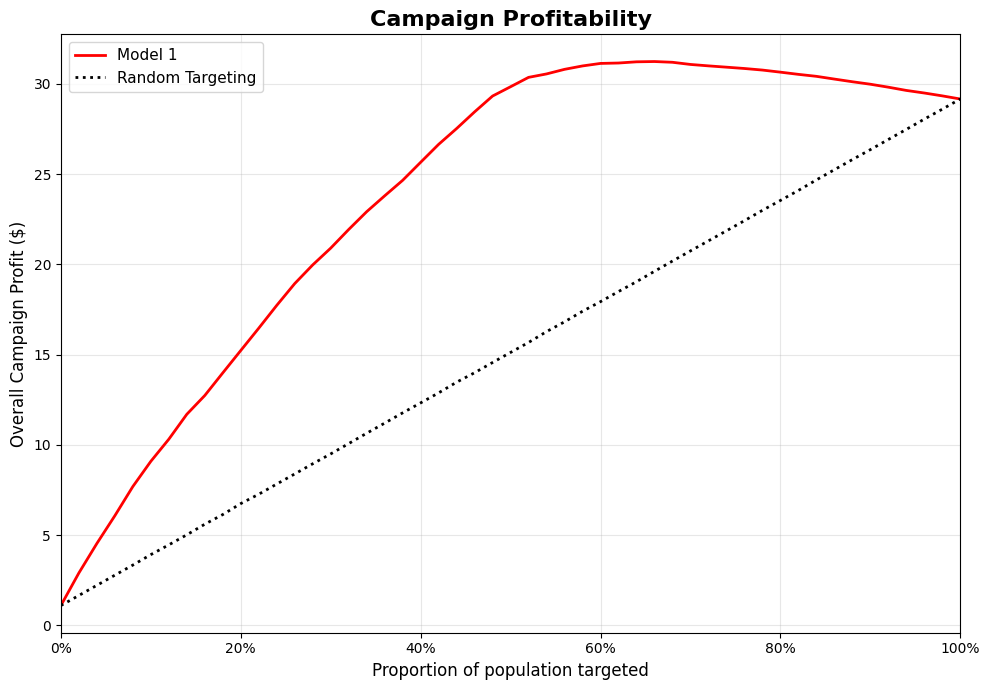

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Policy: top-q by uplift score
# -----------------------------------------------------------
def treatment_policy_top_q(scores, q):
    n = len(scores)
    cutoff = int(np.floor(q * n))
    order = np.argsort(scores)[::-1]
    policy = np.zeros(n, dtype=int)
    policy[order[:cutoff]] = 1
    return policy

def treatment_policy_random(n, q, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    k = int(np.floor(q * n))
    idx = rng.permutation(n)[:k]
    policy = np.zeros(n, dtype=int)
    policy[idx] = 1
    return policy

# -----------------------------------------------------------
# Policy value estimator (HT/IPW, no renormalization)
# -----------------------------------------------------------
def estimate_policy_value(y, w, policy, p_treat=None):
    if p_treat is None:
        p_treat = w.mean()
    p = float(p_treat)
    tt = (policy == 1) & (w == 1)
    cc = (policy == 0) & (w == 0)
    value = (y[tt] / p).sum() + (y[cc] / (1 - p)).sum()
    return value / len(y)

# -----------------------------------------------------------
# Summarize a policy
# -----------------------------------------------------------
def summarize_policy(name, policy, y, w, R, c, p_treat):
    value = estimate_policy_value(y, w, policy, p_treat)
    treat_rate = policy.mean()
    revenue = R * value
    cost = c * treat_rate
    profit = revenue - cost
    return {
        "policy": name,
        "treat_rate": treat_rate,
        "E[Y^pi]": value,
        "revenue": revenue,
        "cost": cost,
        "profit": profit,
    }

# -----------------------------------------------------------
# Evaluation
# -----------------------------------------------------------
p_treat = 0.2  # known experimental p
rng = np.random.default_rng(123)
B = 200

# Create fine-grained q values for smooth curves (0% to 100%)
q_values = np.linspace(0.0, 1.0, 51)  # 51 points from 0% to 100%

# For Model 1 
profits_model1 = []
treat_rates_model1 = []

for q in q_values:
    policy_top = treatment_policy_top_q(tau_test_cf, q)
    out = summarize_policy(f"model1_q{q:.2f}", policy_top, Y_test, W_test, R, c, p_treat)
    profits_model1.append(out["profit"])
    treat_rates_model1.append(out["treat_rate"])

# Random targeting baseline (Monte Carlo average for each q)
profits_random = []
treat_rates_random = []

for q in q_values:
    profits_q = []
    for _ in range(B):
        policy_rand = treatment_policy_random(len(Y_test), q, rng)
        out = summarize_policy("random_tmp", policy_rand, Y_test, W_test, R, c, p_treat)
        profits_q.append(out["profit"])
    profits_random.append(np.mean(profits_q))
    treat_rates_random.append(q)

# -----------------------------------------------------------
# Plot
# -----------------------------------------------------------
plt.figure(figsize=(10, 7))

# Plot Model 1
plt.plot(treat_rates_model1, profits_model1, 'r-', linewidth=2, label='Model 1')

# Plot Model 2 (if available)
# plt.plot(treat_rates_model2, profits_model2, 'b--', linewidth=2, label='Model 2')

# Plot Random Targeting
plt.plot(treat_rates_random, profits_random, 'k:', linewidth=2, label='Random Targeting')

plt.xlabel('Proportion of population targeted', fontsize=12)
plt.ylabel('Overall Campaign Profit ($)', fontsize=12)
plt.title('Campaign Profitability', fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)

# Format x-axis as percentages
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x*100)}%'))

plt.tight_layout()
plt.show()


In [21]:
# Find the maximum profit for Model 1
max_profit_idx = np.argmax(profits_model1)
max_profit = profits_model1[max_profit_idx]
optimal_q = treat_rates_model1[max_profit_idx]

print(f"Model 1 - Maximum Profit: ${max_profit:,.2f}")
print(f"Optimal targeting fraction: {optimal_q:.2%} ({optimal_q:.3f})")
print(f"This means treating {optimal_q:.1%} of the population")

Model 1 - Maximum Profit: $31.24
Optimal targeting fraction: 66.00% (0.660)
This means treating 66.0% of the population


Our model generates higher profits than a random targeting policy at all proportion of population targets, and higher than treating everyone. The maximum profit under our model is achieved at 66%. 